# Link Analysis

# Table of Content

- [Setup](#setup)
- [Hits](#hits)
- [PageRank](#pagerank)
- [SimRank](#simrank)

---
# <a name='setup'></a> Setup

In [1]:
from collections import namedtuple
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Load Data

In [2]:
Edge = namedtuple('Edge', ('source', 'dest'))

In [3]:
def load_graph_gen(filename):
    with open(filename, 'r') as input_file:
        for line in input_file:
            source, dest = line.strip().split(',')
            yield Edge(source, dest)

In [4]:
graph1_gen = load_graph_gen('dataset/graph_1.txt')

In [5]:
G1 = nx.DiGraph(graph1_gen)

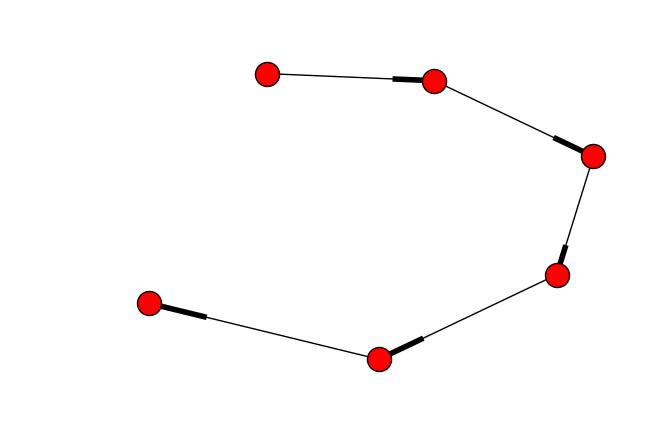

In [6]:
nx.draw(G1)
plt.show()

In [7]:
G2 = nx.DiGraph()
G2.add_edges_from([(1,3),(2,3),(3,4),(4,1)])

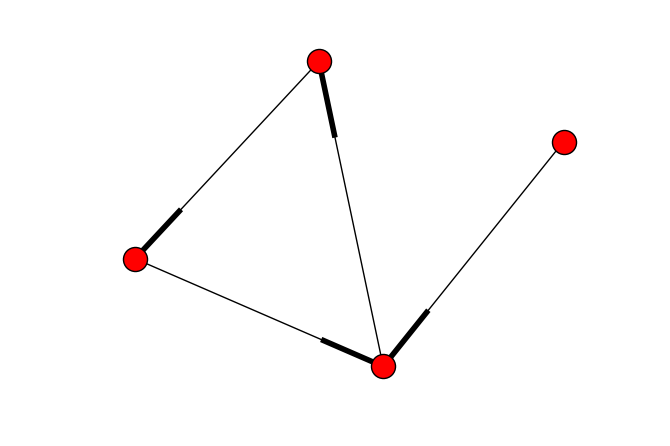

In [8]:
nx.draw(G2)
plt.show()

---
# <a name='hits'></a> Hits

In [9]:
h, a = nx.hits(G1)
print(h)
print(a)

{'2': 0.2, '5': 0.2, '3': 0.2, '4': 0.2, '1': 0.2, '6': 0.0}
{'2': 0.2, '5': 0.2, '3': 0.2, '4': 0.2, '1': 0.0, '6': 0.2}


## self implement of HITS

In [10]:
def initGraph(G):
    for node in G:
        G.add_node(node, authority=1)
        G.add_node(node, hub=1)
    return G

In [11]:
def normalized(G, h, a):
    totalH, totalA, t = 0, 0, 0
    for node in G:
        totalH += h[node]
        totalA += a[node]
    for node in G:
        t += h[node] / totalH - G.node[node]['hub']
        G.node[node]['hub'] = h[node] / totalH
        G.node[node]['authority'] = a[node] / totalA
    return G,t

In [60]:
def authorityHub(G, h, a):
    for node in G:
        h[node], a[node] = 0,0
        for ch in G.successors(node):
            h[node] += G.node[ch]['authority']
        for pa in G.predecessors(node):
            a[node] += G.node[pa]['hub']
    G,t = normalized(G,h,a)
    return G,h,a,t

In [61]:
def HITS(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    h, a = {}, {}
    initGraph(G)
    it, t = 0, 1
    while it < max_iter and t > tol:
        G,h,a,t = authorityHub(G,h,a)
        it += 1
    for node in G:
        h[node] = G.node[node]['hub']
        a[node] = G.node[node]['authority']        
    return h,a

In [62]:
h, a = HITS(G1)
print(h)
print(a)

{'2': 0.2, '5': 0.2, '3': 0.2, '4': 0.2, '1': 0.2, '6': 0.0}
{'2': 0.2, '5': 0.2, '3': 0.2, '4': 0.2, '1': 0.0, '6': 0.2}


In [15]:
G1.successors('1') # = G1.neighbors('1')

['2']

In [16]:
G1.predecessors('2')

['1']

In [17]:
G1.nodes(data=True)

[('2', {'authority': 0.2, 'hub': 0.2}),
 ('5', {'authority': 0.2, 'hub': 0.2}),
 ('3', {'authority': 0.2, 'hub': 0.2}),
 ('4', {'authority': 0.2, 'hub': 0.2}),
 ('1', {'authority': 0.0, 'hub': 0.2}),
 ('6', {'authority': 0.2, 'hub': 0.0})]

In [19]:
def normal(m):
    total = np.sum(m)
    return m/total

In [20]:
def compare(m1, m2):
    result = np.sum(m1) - np.sum(m2)
    return abs(result)

In [65]:
def hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    k = G.number_of_nodes()
    nodeDict, Hub, Auth = {}, {}, {}
    i, it = 0, 0
    for node in G:
        nodeDict[node] = i
        i += 1
        
    A = np.zeros((k, k))
    for node in G:    
        for n in G.neighbors(node):
            A[nodeDict[node]][nodeDict[n]] = 1
    A.shape=(k,k)  
    AT = np.transpose(A)
    
    h0 = np.ones((k,1))
    a0 = np.ones((k,1))    
    
    pre_h = normal(A.dot(a0))
    pre_a = normal(AT.dot(h0))
    
    h = normal(A.dot(pre_a))
    a = normal(AT.dot(pre_h))

    while it <= max_iter and (compare(h, pre_h) + compare(a, pre_a)) > tol:
        pre_h, pre_a = h, a
        h = normal(A.dot(pre_a))
        a = normal(AT.dot(pre_h))
        it += 1
    
    for key in nodeDict.keys():
        Hub[key] = h[nodeDict[key]][0]
        Auth[key] = a[nodeDict[key]][0]
        
    return Hub, Auth

In [66]:
h2, a2 = hits(G1)
print(h2)
print(a2)

{'2': 0.20000000000000001, '5': 0.20000000000000001, '3': 0.20000000000000001, '4': 0.20000000000000001, '1': 0.20000000000000001, '6': 0.0}
{'2': 0.20000000000000001, '5': 0.20000000000000001, '3': 0.20000000000000001, '4': 0.20000000000000001, '1': 0.0, '6': 0.20000000000000001}


In [64]:
h3, a3 = HITS(G1)
print(h3)
print(a3)

{'2': 0.2, '5': 0.2, '3': 0.2, '4': 0.2, '1': 0.2, '6': 0.0}
{'2': 0.2, '5': 0.2, '3': 0.2, '4': 0.2, '1': 0.0, '6': 0.2}


In [56]:
h, a = nx.hits(G1)
print(h)
print(a)

{'2': 0.2, '5': 0.2, '3': 0.2, '4': 0.2, '1': 0.2, '6': 0.0}
{'2': 0.2, '5': 0.2, '3': 0.2, '4': 0.2, '1': 0.0, '6': 0.2}


In [57]:
h2, a2 = hits(G2)
print(h2)
print(a2)

{1: 0.33333333333333331, 2: 0.33333333333333331, 3: 0.16666666666666666, 4: 0.16666666666666666}
{1: 0.25, 2: 0.0, 3: 0.5, 4: 0.25}


In [63]:
h3, a3 = HITS(G2)
print(h3)
print(a3)

{1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25}
{1: 0.25, 2: 0.0, 3: 0.5, 4: 0.25}


In [58]:
h, a = nx.hits(G2)
print(h)
print(a)

{1: 0.49999999813735485, 2: 0.49999999813735485, 3: 1.8626451422920631e-09, 4: 1.8626451422920631e-09}
{1: 3.7252902707063384e-09, 2: 0.0, 3: 0.9999999925494194, 4: 3.7252902707063384e-09}


---
# <a name='pagerank'></a> Page Rank

---
# <a name='simrank'></a> SimRank